## **MODULAR REAL TIME MODELING FOR FINANCIAL INSIGHT GENERATION**

In [89]:
import requests
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
from datetime import datetime

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import cohere
import faiss
from tqdm import tqdm

import praw
import re
from datasets import Dataset
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)
os.chdir("/Users/emmanueladeleye/Documents/DS Projects/Financial Insights Generator/Modular-Real-Time-Financial-News/")
from src.utils import clean_corpus, refine_corpus, news_pull

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/emmanueladeleye/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
load_dotenv()
news_apikey = os.getenv("NEWS_API_KEY")
alpha_vantage_apikey = os.getenv("ALPHA_VANTAGE_API_KEY")
openai_api = os.getenv("openai_api")
client_secret = os.getenv("client_secret")
client_id = os.getenv("client_id")
user_agent = os.getenv("user_agent")
cohere_api = os.getenv("cohere_api")

#### **NewsAPI**

In [3]:
def clean_results_napi(content):
    if not content:
        return ""

    content = re.sub(r'\[\+\d+ chars\]',"",content)    
    content = '\n'.join(line.strip() for line in content.splitlines() if line.strip())

    return content.strip()

def fetch_newsapi(query, num_articles, content_type):
    # The function takes in the users query they intend to analyse for, the number of articles and the content type, that is either full, partial or none
    url = "https://newsapi.org/v2/everything"
    params = {
        "q":query,
        "apiKey":news_apikey,
        "pageSize":num_articles,
        "sortBy":"publishedAt",
        "content":content_type
    }
    response = requests.get(url, params=params).json()
    articles = response.get("articles", [])
    parsed_articles = [
        {
        "title": a["title"], 
        "content":a.get("content") or a.get("description", ""), # Fallback 
        "source": "NewsAPI", 
        "date": a["publishedAt"]
    } 
            for a in articles]
    
    df = pd.DataFrame(parsed_articles)
    df['content'] = df['content'].apply(clean_results_napi)
    
    return df

#### **Alphavantage**

In [4]:
def fetch_alphavantage(query_tickers):
    # The function takes in the users query they intend to analyse for, the number of articles and the content type, that is either full, partial or none
    url = "https://www.alphavantage.co/query"
    params = {
        "function":"NEWS_SENTIMENT",
        "tickers":query_tickers,
        "apikey":alpha_vantage_apikey,
        "sort": "LATEST"
    }

    try:
        response = requests.get(url, params=params)
        response.raise_for_status() # this will raise http errors
        data = response.json()
        articles = data.get("feed", [])

        
        parsed_articles = []
        for article in articles:
            # Parse date from "20250121T120000" to datetime
            pub_date = datetime.strptime(article['time_published'], "%Y%m%dT%H%M%S")

            # Getting sentiment scores for the queried tickers(s)
            ticker_sentiments = [
                ts for ts in article.get("ticker_sentiment", [])
                if ts['ticker'] in query_tickers.split(",")
            ]

            parsed_articles.append({
                "title":article['title'],
                "content":article.get("summary", ""),
                "source":"AlphaVantage",
                "date":pub_date,
                "url":article.get("url", ""),
                "sentiment_label":article.get("overall_sentiment_label", "neutral"),
                "relevance_score": float(article.get("relevance_score", 0)),
                "ticker_sentiment": ticker_sentiments
                
            })
        
        df = pd.DataFrame(parsed_articles)
        
        return df
        
    except Exception as e:
        print(f"AlphaVantage Error: {e}")
        return []

#### **RSS Feed Data**

In [5]:
import feedparser

In [6]:
feed = feedparser.parse("https://feeds.bloomberg.com/markets/news.rss")
articles = []
query = "Tarrifs"

for entry in feed.entries:
    print(entry.title)

Stocks Slip as Bull Run’s Third Year Nears Close: Markets Wrap
European Stocks Close Best Year Since 2021 Near Record Highs
US Signs $16 Billion of Health Agreements With African Nations
Tycoon Elumelu Buys Stake in Biggest Nigerian Oil Explorer
Gold and Silver Stumble at the End of Best Year Since the 1970s
Sugar Set for Biggest Annual Drop Since 2017 on Surplus Outlook
Cold Snap Lifts French Nuclear Output to Highest Since 2019
Argentina Still $2.4 Billion Short for January Bond Payments
Copper Set for Biggest Annual Gain Since 2009 on Supply Bets
Dollar Set for Worst Year Since 2017 With Fed Drama Center Stage
These Stocks Are the Market’s Biggest Winners and Losers in 2025
Buying the Dips Paid Off in Stomach-Churning Markets This Year
China Limits Foreign Beef Imports to Protect Local Farmers
Indian Stocks Post Worst Asia Underperformance in Three Decades
Europe Gas Heads for Sharp Annual Drop as LNG Surge Calms Market
Oil Heads for Deepest Annual Loss Since 2020 on Surplus Concern

In [7]:
def fetch_rss(feed_url, query=None):
    """
    Fetches and selects articles from an RSS feed

    Args:
        feed_url (str, compulsory) and query (str, optional) - defaults to none if blank

    Output:
    Returns a list of dictionaries with article details    
    """

    feed = feedparser.parse(feed_url)    

    articles = []

    for entry in feed.entries:
        
        # Safely get title and content (summary/description)
        title = entry.get('title', '')
        summary = entry.get('summary', entry.get('description', ''))

        # Checking if the query matches the title or summary
        if query and query.lower() not in (title + summary).lower():
            continue # this skips non-matching articles
        
        # Parse the publication date
        pub_date = datetime(*entry.published_parsed[:6]) if hasattr(entry, "published_parsed") else None

        articles.append({
            "title": entry.title,
            "content": entry.summary,
            "source": feed_url,
            "date": pub_date,
            "url": entry.link
        })

    return articles

feed_urls = [
    "https://feeds.bloomberg.com/technology/news.rss",
    "https://feeds.bloomberg.com/markets/news.rss",
    "https://feeds.bloomberg.com/politics/news.rss",
    "https://feeds.bloomberg.com/businessweek/news.rss",
    "https://feeds.bloomberg.com/economics/news.rss",
    "https://feeds.bloomberg.com/industries/news.rss",
    "https://feeds.bloomberg.com/bview/news.rss",
    "https://feeds.bloomberg.com/wealth/news.rss"
]

def fetch_multiple_rss(feed_urls=feed_urls, query=None):

    all_articles = []
    for url in feed_urls:
        articles = fetch_rss(url, query)
        all_articles.extend(articles)

    df = pd.DataFrame(all_articles)
    return df    

#### **Reddit Posts**

In [8]:
reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent
)

In [9]:
for post in reddit.subreddit("wallstreetbets").hot(limit=5):
    print(post.title)

Daily Discussion Thread for December 31, 2025
Wendy's newest hire starts tomorrow
Stegosaurus pattern is back on SPY
China to restrict silver exports, echoing rare earths playbook
‪Tomorrow is Warren Buffet’s last day as CEO of Berkshire Hathaway! ‬


In [10]:
def fetch_reddit(query, percent, subreddit='wallstreetbets', limit=1000):
    """
    Fetches posts from a subreddit based on a query.
    
    Args:
        query (str): Keyword to search for (e.g., "Tesla").
        subreddit (str): Subreddit to search in (default: "wallstreetbets").
        limit (int): Maximum number of posts to fetch (default: 1000).
    
    Returns:
        List of dicts with post details.
    """
    # Initializing Reddit API client
    reddit = praw.Reddit(client_id=client_id, client_secret=client_secret, user_agent=user_agent)
    sub = reddit.subreddit(subreddit)
    posts = sub.search(query, limit=limit)

    # Parsing the posts
    parsed_posts = []
    for post in posts:
        parsed_posts.append({
            "title": post.title,
            "content": post.selftext,
            "source": f"Reddit r/ {subreddit}",
            "date": datetime.fromtimestamp(post.created_utc),
            "url": f"https://reddit.com{post.permalink}",
            "upvotes": post.score,
            "comments": post.num_comments
        })
        
    df = pd.DataFrame(parsed_posts)
    sorted_df = df.sort_values(by='upvotes', ascending=False).reset_index(drop=True)
    slice_df = sorted_df[:int(percent*len(sorted_df))]
    return slice_df

#### **Data Integration**

In [ ]:
def news_pull(s_query, s_type, include_media, media_percent=None):

    if include_media==True:
        if isinstance(media_percent, float):
            if s_type == 'general': # specifying general drops ticker based search from alphaadvantage
                napi_df = fetch_newsapi(s_query, 50, "full")
                aapi_df = None
                reddit_df = fetch_reddit(query=s_query, percent=media_percent)
                rss_df = fetch_multiple_rss(query=s_query)
            
            elif s_type == 'ticker': # specifying ticker includes alphaadvantage ticker based news
                napi_df = fetch_newsapi(s_query, 50, "full")
                aapi_df = fetch_alphavantage(s_query)
                reddit_df = fetch_reddit(query=s_query, percent=0.3)
                rss_df = fetch_multiple_rss(query=s_query)

        else:
            print('Enter a valid percentage value for media articles')
    
    elif include_media==False:
        if s_type == 'general':
            napi_df = fetch_newsapi(s_query, 50, "full")
            aapi_df = None
            reddit_df = None
            rss_df = fetch_multiple_rss(query=s_query)
        
        elif s_type == 'ticker':
            napi_df = fetch_newsapi(s_query, 50, "full")
            aapi_df = fetch_alphavantage(s_query)
            reddit_df = None
            rss_df = fetch_multiple_rss(query=s_query)   

    def consolidate_text(include_media, media_percent):
        napi_df, aapi_df, reddit_df, rss_df = news_pull('stocks', 'general', include_media=True, media_percent=0.3) # including reddit news
        dfs = [df for df in [napi_df, aapi_df, reddit_df, rss_df] if df is not None]
        full_response = pd.concat(dfs, axis=0).reset_index(drop=True)
        full_response['full_response'] = " Source: " + full_response['source'] + "\n" + full_response['title'] + '\n' + full_response['content']
        
        texts_list = full_response['title'] + '\n' + full_response['content']

        # Stack them all into a single string
        all_text = "\n".join(texts_list)
        return full_response, all_text
    
    full_response, all_text = consolidate_text(include_media, media_percent)                                  

    return full_response, all_text

In [ ]:
full_response, all_text = news_pull('stocks', 'general', include_media=True, media_percent=0.3) # including reddit news

In [19]:
full_response['source'].value_counts()

source
Reddit r/ wallstreetbets                           70
NewsAPI                                            50
https://feeds.bloomberg.com/markets/news.rss        7
https://feeds.bloomberg.com/technology/news.rss     3
https://feeds.bloomberg.com/industries/news.rss     1
Name: count, dtype: int64

#### **Processing The Text Data**

In [21]:
### cleaning the corpus

def clean_corpus(text):

    """
    Comprehensive text cleaning function that is built to handle
    - Newlines and tabs
    - Irrelevant prefix and suffix (e.g skip comments)
    - Javascript snippets
    - URLs
    - Special characters and excessive whitespace
    - Short sentences
    """
    if not isinstance(text,str):
        return ""

    # Remove newlines, tabs, and excessive whitespaces
    text = " ".join(text.split())

    # Removing javascript snippets and HTML tags
    text = re.sub(r'{.*?}', "", text)
    text = re.sub(r'href.*?\)', "", text)
    text = re.sub(r'<.*?>', "", text)

    # Removing "skip to comments" and similar patterns
    text = re.sub(r'skip to comments.*?', '', text, flags=re.IGNORECASE)
    text = re.sub(r'Click here to view the full post.*', '', text, flags=re.IGNORECASE)
    text = re.sub(r"click 'Accept all'.*", '', text, flags=re.IGNORECASE)

    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Remove special characters
    text = re.sub(r"""[^\w\s.,;:!?'"-]""", '', text)

    # Remove standalone single/double quotes
    text = re.sub(r'\s[\'"]\s',' ', text)

    # Remove trailing/leading whitespaces
    text = text.strip()

    return text

def refine_corpus(corpus, min_length=70):

    """
    Refining corpus by splitting into robust sentences, applying comprehensive text cleaning and filtering the corpus length
    """

    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s', corpus)

    cleaned_sentences = []
    for sentence in sentences:
        # Cleaning corpus
        clean_sent = clean_corpus(sentence)

        if len(clean_sent) >= min_length:
            # Ensuring sentences end with a proper punctuation
            if not clean_sent.endswith(('.','?','!')):
                clean_sent +='.'
            cleaned_sentences.append(clean_sent)    
    
    return  cleaned_sentences

In [22]:
cleaned_corpus = refine_corpus(all_text)

In [90]:
full_response, all_text = news_pull('stocks', 'general', include_media=True, media_percent=0.3) # including reddit news
cleaned_corpus = refine_corpus(all_text)

TypeError: Scraper.fetch_multiple_rss() missing 2 required positional arguments: 'feed_urls' and 'num_articles'

#### **Search Option 1 - Cohere Embeddings**

In [ ]:
co = cohere.Client(cohere_api)

In [30]:
responses = co.embed(texts=cleaned_corpus, input_type='search_document').embeddings
embeds = np.array(responses)
print('Corpus Embedding Shape: {}\n'.format(embeds.shape))
dim = embeds.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(np.float32(embeds))

def search(s_query, number_of_results):
    query_embed = co.embed(texts=[s_query], input_type='search_query').embeddings[0]
    distances, similar_items_ids = index.search(np.float32([query_embed]), number_of_results)
    texts_np = np.array(cleaned_corpus)
    results = pd.DataFrame(data={'texts':texts_np[similar_items_ids[0]], 'distance':distances[0]})
    print(f'Query:{s_query}\nNearest Neighbors')
    return results

Corpus Embedding Shape: (136, 4096)



In [35]:
search('Attack on Putin', 5)

Query:Attack on Putin
Nearest Neighbors


,texts,distance
0,Someone purchased 1.3 BILLION worth of AAPL st...,8819.003906
1,Jesus fucking Christ you absolute dolts Don't ...,9214.301758
2,Billionaire Investor Mark Cuban Says Reddit St...,10087.401367
3,After their decades of buy blockbuster BLIAQ m...,10572.330078
4,This FTX situation gets more insane by the min...,10947.850586


#### **Search Option 2 - BM25 + Reranking**

In [37]:
from rank_bm25 import BM25Okapi
from sklearn.feature_extraction import _stop_words
import string

from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.retrievers import BM25Retriever, EnsembleRetriever

In [42]:
# similarity + keyword match
def bm25_tokenizer(text):
    tokenizer_doc = []
    for token in text.lower().split():
        token = token.strip(string.punctuation)

        if len(token)>0 and token not in _stop_words.ENGLISH_STOP_WORDS:
            tokenizer_doc.append(token)

    return tokenizer_doc

def keyword_and_reranking_search(s_query, top_k=3, num_candidates=10, bm25=None):
    print(f'Input Query: {s_query}')

    #### BM25 search lexical search
    bm25_scores = bm25.get_scores(bm25_tokenizer(query))
    top_n = np.argpartition(bm25_scores, -num_candidates)[-num_candidates:]
    bm25_hits = [{'corpus_id':idx, 'score':bm25_scores[idx]} for idx in top_n]
    bm25_hits = sorted(bm25_hits, key=lambda x: x['score'], reverse=True)

    print(f'Top-{top_k} Lexical Search (BM25) Hits')

    for hit in bm25_hits[0:top_k]:
        print('\t{:.3f}\t{}'.format(hit['score'], cleaned_corpus[hit['corpus_id']].replace('\n',' ')))

    # Adding reranking
    docs = [cleaned_corpus[hit['corpus_id']] for hit in bm25_hits]

    print(f'\nTop-{top_k} Hits By Rank-API ({len(bm25_hits)} BM25 Hits Re-Ranked)')
    results = co.rerank(query=s_query, documents=docs, top_n=top_k, return_documents=True)

    for hit in results.results:
        print('\t{:.3f}\t{}'.format(hit.relevance_score, hit.document.text.replace('\n','')))

In [39]:
tokenized_corpus = []
for passage in tqdm(cleaned_corpus):
    tokenized_corpus.append(bm25_tokenizer(passage))

bm25 = BM25Okapi(tokenized_corpus)    

100%|██████████| 136/136 [00:00<00:00, 92691.80it/s]


In [43]:
keyword_and_reranking_search(s_query='China\'s position on US tarrifs', bm25=bm25)

Input Query: China's position on US tarrifs
Top-3 Lexical Search (BM25) Hits
	0.000	- first text file, search "GME", and you'll see the fails to deliver suggesting a real number in the millions, unheard of - these are purchased shares that couldn't be found.
	0.000	After an initial uptick it will just fizzle out and you'll be left bagholding.
	0.000	They cannot cover anywhere near this price level because the shares don't exist.

Top-3 Hits By Rank-API (10 BM25 Hits Re-Ranked)
	0.080	Tariffs to Set US Materials Up for Best Earnings in Five Years While tariffs and shaky consumer confidence continue to create headwinds for corporate America, theyre set to lift earnings growth for US materials stocks to the highest in five years.
	0.046	When it comes time for them to pay up, expect the price to drop first.
	0.044	I think the chance of seeing big upword moves is as high as its ever been.


#### **Search Option 3 - Implementing Langchain**

In [44]:
from langchain.output_parsers import StructuredOutputParser, ResponseSchema
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI

import openai

In [45]:
response_schemas = [
    ResponseSchema(name="key_insights", description='3-5 bullet points summarizing key insights/outlook on the topic'),
    ResponseSchema(name="key_drivers", description='Main economic/politcal indicators driving the topic'),
    ResponseSchema(name='risks', description='Potential risks associated with the topic'),
    ResponseSchema(name='sentiment', description='Overall social sentiment (positive/negative/neutral with evidence) and degree of sentiment in percentage')    
]
output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
format_instructions = output_parser.get_format_instructions()

In [46]:
def analyze_text(s_query, relevant_text):
    
    # initiate llm model
    prompt = ChatPromptTemplate.from_template(
    """
    Analyze the following news corpus regarding {query} and extract:
    {format_instructions}
    
    Corpus:
    {text}
    
    """)
    #client = openai.OpenAI(api_key=openai_key)
    llm = ChatOpenAI(
        model="gpt-3.5-turbo",
        temperature=0.3,
        openai_api_key=openai_api  # Pass key directly or use environment variable
    )

    messages = prompt.format_messages(
        query = s_query,
        text = relevant_text,
        format_instructions=format_instructions
    )

    response = llm(messages)
    return output_parser.parse(response.content)

In [64]:
def create_search_index(full_text):
    # Split text into chunks
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200
    )
    chunks = text_splitter.split_text(full_text)

    # creating searchable index
    embeddings = OpenAIEmbeddings(openai_api_key=openai_api)
    return FAISS.from_texts(chunks, embeddings)    

def analyze_with_semantic_search(s_query, text_list, n_results=10):
    full_texts = " ".join(text_list) if isinstance(text_list, list) else text_list
    # creating vector index on full corpus
    index = create_search_index(full_texts)

    # retreiving relevant chunks
    bm25_retriever = BM25Retriever.from_texts(full_texts)
    faiss_retriever = index.as_retriever()
    ensemble_retriever = EnsembleRetriever(
        retrievers=[bm25_retriever, faiss_retriever], 
        weights=[0.4,0.6]
    )
    
    relevant_text = ensemble_retriever.get_relevant_documents(s_query)
    
    return analyze_text(s_query, relevant_text), relevant_text

#### **Testing**

In [48]:
## reruning semantic search on data inclusive of reddit posts
s_query = 'Russia Ukraine war impact on global economy'
full_texts = cleaned_corpus
result = analyze_with_semantic_search(s_query, full_texts, n_results=5)

print(result)

/var/folders/lp/sq72yvgs40b2km5v8986p_g80000gn/T/ipykernel_7349/4040503641.py:10: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings(openai_api_key=openai_api)
/var/folders/lp/sq72yvgs40b2km5v8986p_g80000gn/T/ipykernel_7349/4040503641.py:26: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  relevant_text = ensemble_retriever.get_relevant_documents(s_query)
/var/folders/lp/sq72yvgs40b2km5v8986p_g80000gn/T/ipykernel_7349/2975228536.py:14: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and w

{'key_insights': '1. Russian stocks facing significant pressure and selling due to the war in Ukraine. 2. Foreign-held shares of Russian stocks may not be permitted to be sold on the Moscow Exchange. 3. Global markets experiencing volatility and uncertainty. 4. US materials stocks expected to have the best earnings in five years due to tariffs. 5. Spanish and UK stocks performing well despite geopolitical tensions.', 'key_drivers': 'Geopolitical tensions between Russia and Ukraine. Global market sentiment and uncertainty. Tariffs impacting US materials stocks. Earnings outlook for Spanish and UK stocks.', 'risks': 'Potential risk of further decline in Russian stocks. Uncertainty in global markets due to geopolitical tensions. Impact of tariffs on US materials stocks. Foreign policy risks affecting Spanish and UK stocks.', 'sentiment': 'Negative sentiment towards Russian stocks with investors unloading shares. Neutral sentiment towards global markets with volatility. Positive sentiment 

In [51]:
display(pd.DataFrame([result]).T)

,0
key_insights,1. Russian stocks facing significant pressure ...
key_drivers,Geopolitical tensions between Russia and Ukrai...
risks,Potential risk of further decline in Russian s...
sentiment,Negative sentiment towards Russian stocks with...


In [ ]:
## rerunning semantic search on data exclusive of reddit posts
s_query_no_reddit = 'Russia Ukraine war impact on global economy'
full_texts_no_reddit = cleaned_corpus
result_2 = analyze_with_semantic_search(s_query_no_reddit, full_texts, n_results=5)

print(result_2)

{'key_insights': '1. War with top trade partners impacting investor risk appetite. 2. Cryptocurrency trading in line with stocks indicating uncertainty for US currency. 3. European stocks rise on hopes of tariff pause by Trump administration. 4. NFT marketplace gaining traction for trading digital items. 5. Markets reacting to trade-war risks with volatility.', 'key_drivers': "Trade tensions with top partners, US currency stability, Trump administration's tariff policies, NFT marketplace adoption, overall market volatility.", 'risks': 'Potential risks include prolonged trade tensions impacting global economy, currency instability, market uncertainty due to tariff policies, and volatility in digital asset trading.', 'sentiment': "Overall sentiment is neutral with a slight negative bias due to uncertainty and market volatility. Evidence from the corpus includes phrases like 'leaving investors unwilling to take on too much risk' and 'fast-evolving tariff war'. Sentiment degree is 40% nega

#### **Evaluation**

In [52]:
from ragas import evaluate
from ragas.metrics import (faithfulness, answer_relevancy, context_recall, context_precision)

/var/folders/lp/sq72yvgs40b2km5v8986p_g80000gn/T/ipykernel_7349/3316452575.py:2: DeprecationWarning: Importing faithfulness from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import faithfulness
  from ragas.metrics import (faithfulness, answer_relevancy, context_recall, context_precision)
/var/folders/lp/sq72yvgs40b2km5v8986p_g80000gn/T/ipykernel_7349/3316452575.py:2: DeprecationWarning: Importing answer_relevancy from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import answer_relevancy
  from ragas.metrics import (faithfulness, answer_relevancy, context_recall, context_precision)
/var/folders/lp/sq72yvgs40b2km5v8986p_g80000gn/T/ipykernel_7349/3316452575.py:2: DeprecationWarning: Importing context_recall from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.

In [53]:
str(result)

"{'key_insights': '1. Russian stocks facing significant pressure and selling due to the war in Ukraine. 2. Foreign-held shares of Russian stocks may not be permitted to be sold on the Moscow Exchange. 3. Global markets experiencing volatility and uncertainty. 4. US materials stocks expected to have the best earnings in five years due to tariffs. 5. Spanish and UK stocks performing well despite geopolitical tensions.', 'key_drivers': 'Geopolitical tensions between Russia and Ukraine. Global market sentiment and uncertainty. Tariffs impacting US materials stocks. Earnings outlook for Spanish and UK stocks.', 'risks': 'Potential risk of further decline in Russian stocks. Uncertainty in global markets due to geopolitical tensions. Impact of tariffs on US materials stocks. Foreign policy risks affecting Spanish and UK stocks.', 'sentiment': 'Negative sentiment towards Russian stocks with investors unloading shares. Neutral sentiment towards global markets with volatility. Positive sentiment

In [55]:
financial_eval_data = {
    "question": [
        "How has the conflict affected the energy sector specifically?",
        "Which specific European indices showed the most resilience?"
    ],
    "sub_query": [
        "impact of Russia Ukraine war on oil and gas stocks 2023",
        "European stock market performance Russia war 2023 FTSE vs DAX"
    ],
    "ground_truth": [
        "Significant volatility in energy prices; windfall profits for global oil majors; shift in European energy dependency.",
        "FTSE 100 often outperformed due to commodity exposure; DAX faced pressure due to industrial energy costs."
    ]
}

In [78]:
results_data = {
    "question": [],
    "answer": [],
    "contexts": [],
    "ground_truth": []
}

full_texts = cleaned_corpus
for query in financial_eval_data['sub_query']:
    result, relevant_text = analyze_with_semantic_search(query, full_texts, n_results=5)
    results_data['question'].append(query)
    results_data['answer'].append(result['key_insights'])
    results_data['contexts'].append([doc.page_content for doc in relevant_text])
    results_data['ground_truth'].append(financial_eval_data['ground_truth'][financial_eval_data['sub_query'].index(query)])

In [79]:
results_data

{'question': ['impact of Russia Ukraine war on oil and gas stocks 2023',
  'European stock market performance Russia war 2023 FTSE vs DAX'],
 'answer': ['1. Russian stocks like Gazprom, Sberbank, Lukoil are facing pressure and investors are unloading shares. 2. ADRs of Russian stocks will be decoupled from their prices at MOEX. 3. Russian stocks are expected to plummet to zero. 4. US liquidity in Russian stocks is also diminishing. 5. European markets are also impacted by the war.',
  '1. European stocks closed the year near all-time highs, with Spain and the UK showing strong performance. 2. Chinese stocks are on track for their best year since 2017. 3. Russian stocks are facing significant pressure and investors are advised against buying the dip. 4. US materials stocks are expected to have the best earnings in five years due to tariffs. 5. Artificial intelligence trade is driving technology pick-and-shovel stocks.'],
 'contexts': [["Ive ever seen on Reddit. Do you think this sub gre

In [66]:
os.environ["OPENAI_API_KEY"] = openai_api

In [67]:
gpt_turbo = ChatOpenAI(model="gpt-3.5-turbo")
openai_embeddings = OpenAIEmbeddings()

In [76]:
results_data

{'question': ['impact of Russia Ukraine war on oil and gas stocks 2023',
  'European stock market performance Russia war 2023 FTSE vs DAX'],
 'answer': ["1. Investors are unloading Russian stocks like Gazprom, Sberbank, Lukoil due to pressure and liquidity concerns. 2. Foreign-held shares won't be permitted to be sold on MOEX even when it opens. 3. Russian stocks are expected to plummet to zero. 4. ADRs will be decoupled from their respective prices at MOEX. 5. Spanish stocks are experiencing their best year since 1993 driven by banks.",
  '1. European stocks close best year since 2021 near record highs. 2. Russian stocks facing significant pressure and potential collapse. 3. Chinese stocks on track for best year since 2017. 4. US materials stocks expected to have best earnings in five years. 5. Indian equities post worst Asia underperformance in three decades.'],
 'contexts': ["Ive ever seen on Reddit. Do you think this sub grew 10x in the last two years because of the quality DD text

In [80]:
eval_dataset = Dataset.from_dict(results_data)

metrics = [faithfulness, answer_relevancy, context_recall, context_precision]
scores = evaluate(eval_dataset, metrics, llm=gpt_turbo, embeddings=openai_embeddings)

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.


In [81]:
df_results = scores.to_pandas()
df_results

,user_input,retrieved_contexts,response,reference,faithfulness,answer_relevancy,context_recall,context_precision
0,impact of Russia Ukraine war on oil and gas st...,[Ive ever seen on Reddit. Do you think this su...,"1. Russian stocks like Gazprom, Sberbank, Luko...",Significant volatility in energy prices; windf...,0.800000,0.838616,0.0,0.000000
1,European stock market performance Russia war 2...,"[shares slipped in thin trading, while the Eur...",1. European stocks closed the year near all-ti...,FTSE 100 often outperformed due to commodity e...,0.888889,0.828688,0.0,0.333333


In [84]:
df_results["user_input"][0]

'impact of Russia Ukraine war on oil and gas stocks 2023'

In [85]:
df_results["response"][0]

'1. Russian stocks like Gazprom, Sberbank, Lukoil are facing pressure and investors are unloading shares. 2. ADRs of Russian stocks will be decoupled from their prices at MOEX. 3. Russian stocks are expected to plummet to zero. 4. US liquidity in Russian stocks is also diminishing. 5. European markets are also impacted by the war.'

In [86]:
df_results["reference"][0]

'Significant volatility in energy prices; windfall profits for global oil majors; shift in European energy dependency.'

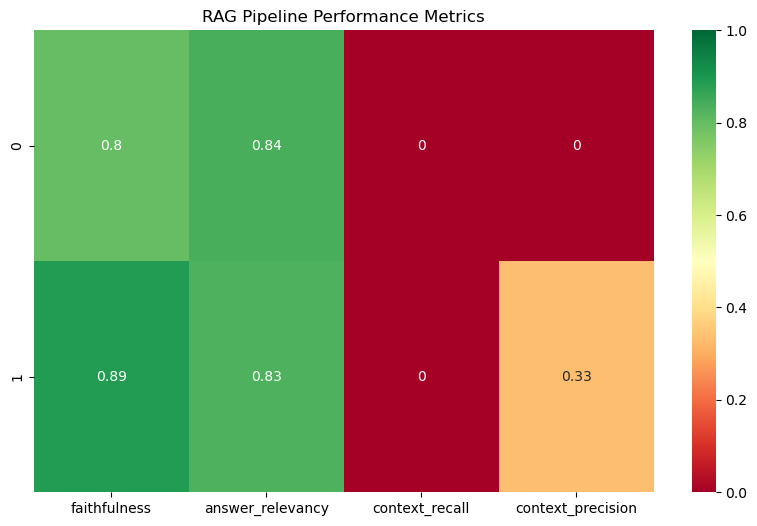

Potential Hallucinations:


In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap of scores
plt.figure(figsize=(10, 6))
sns.heatmap(df_results.iloc[:, 4:], annot=True, cmap="RdYlGn", vmin=0, vmax=1)
plt.title("RAG Pipeline Performance Metrics")
plt.show()

# Print low-faithfulness examples (Potential Hallucinations)
print("Potential Hallucinations:")
low_faith = df_results[df_results["faithfulness"] < 0.7]
for idx, row in low_faith.iterrows():
    print(f"Q: {row['user_input']}")
    print(f"A: {row['response']}")
    print("---")